# Clustering for gevtevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import preprocessing

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 'gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/normalized_spectra.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.013537,0.343081,0.020826,0.143005,0.330419,0.0,0.0,0.000000,0.000000,0.0,...,0.012135,0.004136,0.000407,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,0.013335,0.013325,0.000805,0.014451,0.004808,0.0,0.0,0.004396,0.019638,0.0,...,0.007655,0.004429,0.002622,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,0.001682,0.042624,0.002587,0.017767,0.041051,0.0,0.0,0.000000,0.000000,0.0,...,0.001508,0.000514,0.000051,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.0,0.000000,0.000000,0.0,...,0.000969,0.000719,0.001111,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.012809,0.324638,0.019706,0.135318,0.312657,0.0,0.0,0.000000,0.000000,0.0,...,0.011482,0.003914,0.000385,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
non_normalized_spectra = spectra.copy()

In [7]:
x = spectra[spectrum_columns].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
spectra[spectrum_columns] = pd.DataFrame(x_scaled)

In [8]:
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.113938,1.000000,0.065519,1.000000,0.927864,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.821311,0.095932,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,0.112203,0.027033,0.000756,0.088886,0.000000,0.0,0.0,1.0,1.0,0.0,...,0.630812,0.879485,0.618608,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,0.012054,0.113482,0.006522,0.112385,0.103278,0.0,0.0,0.0,0.0,0.0,...,0.124240,0.102039,0.011919,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,0.095563,0.368768,0.002184,0.488264,0.220059,0.0,0.0,0.0,0.0,0.0,...,0.079838,0.142818,0.262021,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.107684,0.945584,0.061898,0.945517,0.877250,0.0,0.0,0.0,0.0,0.0,...,0.946244,0.777161,0.090775,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


In [9]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [10]:
def build_images(spectra_distances, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(spectra_distances, n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

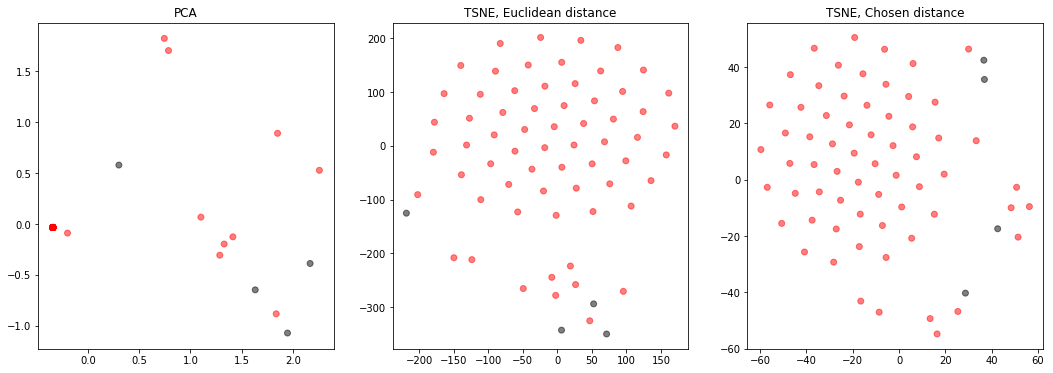

Clustering


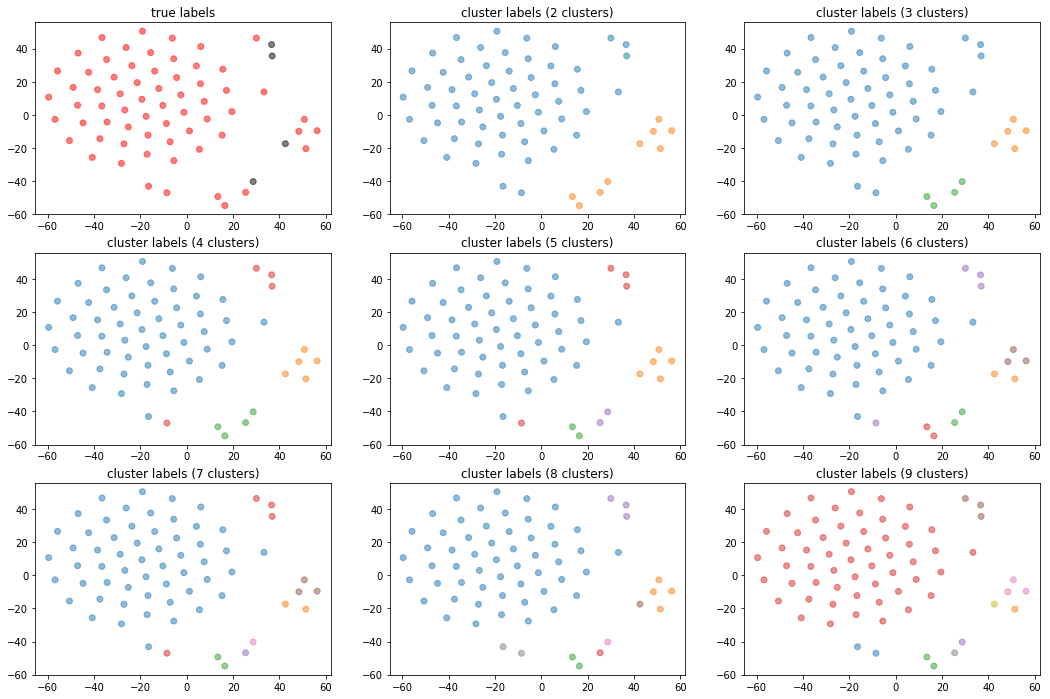

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.934251,0.796188,0.744884,0.797661,0.617010,0.0,0.024164,0.001441,0.001867,0.030078,...,0.0,0.00,0.00,0.00,0.0,0.007705,0.015112,0.014439,0.024132,0.028947
1,0.040725,0.173765,0.006340,0.228919,0.109163,0.0,0.032464,0.002048,0.006183,0.000000,...,0.0,0.00,0.00,0.00,0.0,0.100412,0.030075,0.048133,0.062062,0.078804
2,0.083793,0.495035,0.045927,0.508723,0.456168,0.0,0.154520,0.255480,0.261190,0.122739,...,0.0,0.25,0.25,0.25,0.0,0.628525,0.732722,0.724355,0.719652,0.239454


In [11]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

* ### euclidean distance

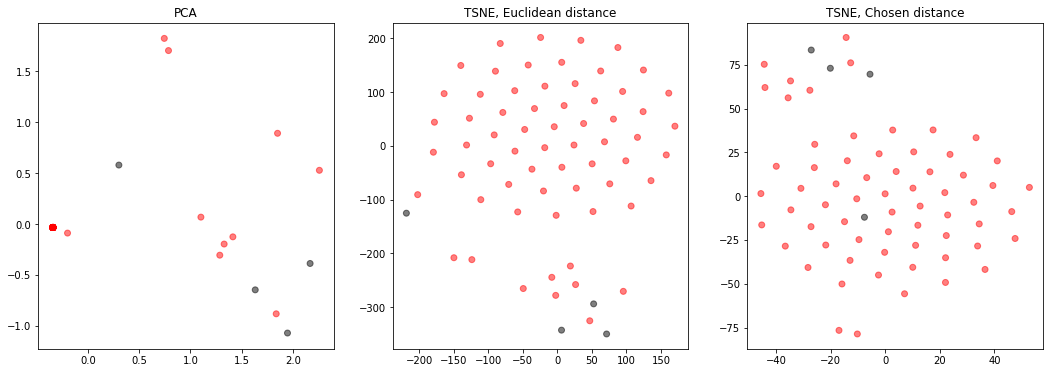

Clustering


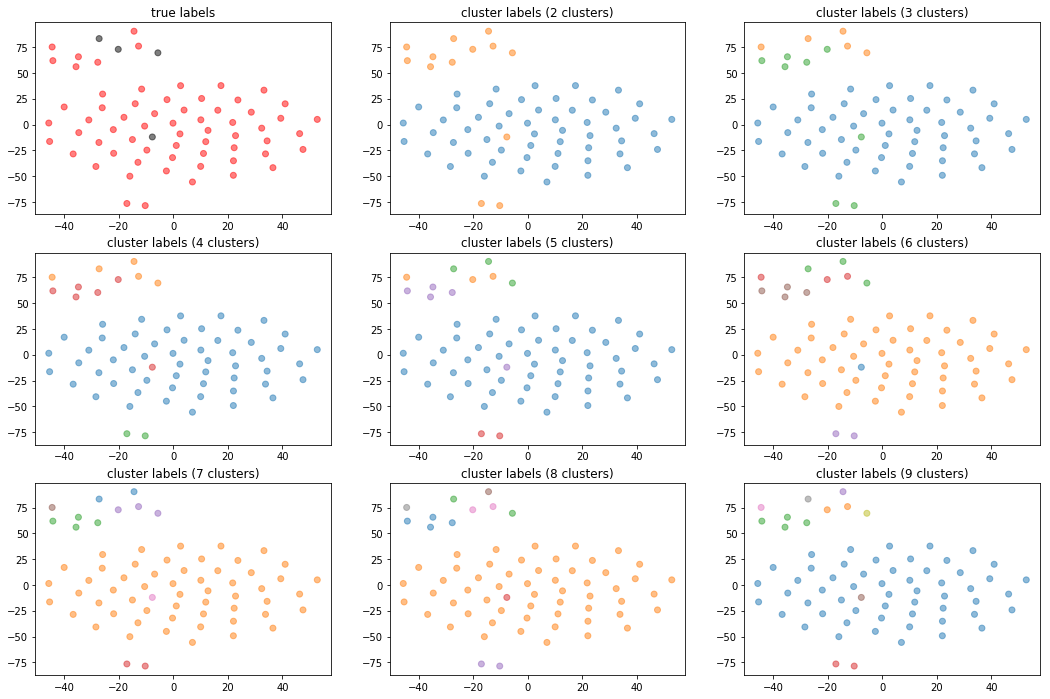

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.049104,0.018112,0.017292,0.047830,0.007118,0.0,4.087502e-01,2.213899e-01,0.230967,0.45311,...,0.0,0.2,0.2,0.2,0.0,0.174657,0.352567,0.334347,0.456572,0.295800
2,0.059852,0.433540,0.144890,0.463384,0.418866,0.0,2.028978e-02,1.279690e-03,0.003865,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.324686,0.276256,0.289781,0.291229,0.197591


In [12]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

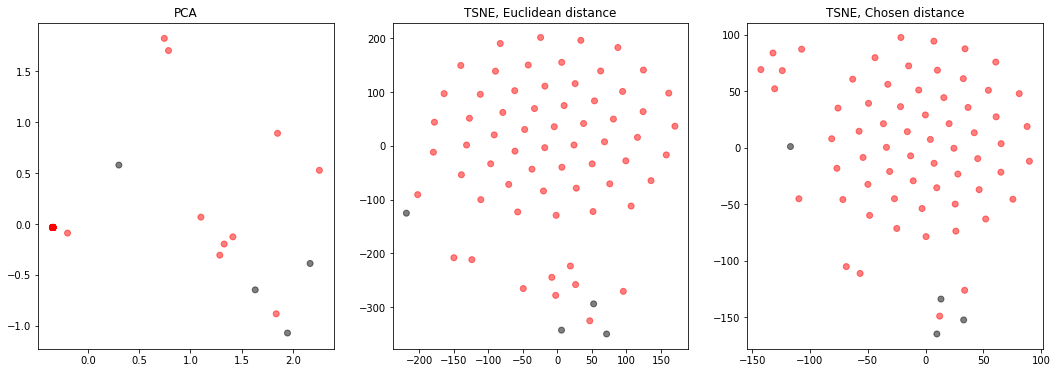

Clustering


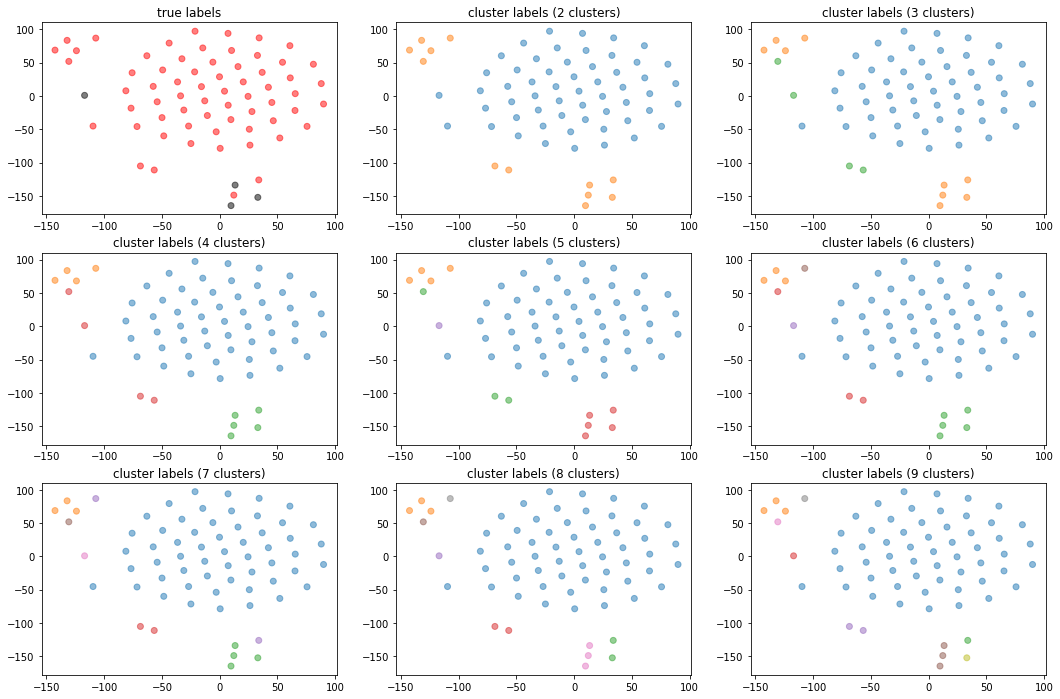

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.032410,0.146298,0.002177,0.182064,0.096857,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.080992,0.044151,0.053610,0.055831,0.044000
2,0.025689,0.023861,0.021667,0.049274,0.013779,0.0,4.412138e-01,2.234374e-01,0.237151,0.45311,...,0.0,0.2,0.2,0.2,0.0,0.115426,0.197415,0.190897,0.256572,0.155125
3,0.105729,0.771451,0.043200,0.811260,0.675058,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.735109,0.654723,0.675361,0.580430,0.149576
4,0.053566,0.653909,1.000000,0.616959,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.149182,0.113426,0.131340,0.421050,1.000000
5,0.127907,0.032420,0.001113,0.102921,0.001878,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.296155,0.775761,0.717251,1.000000,0.703375


In [13]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 6)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

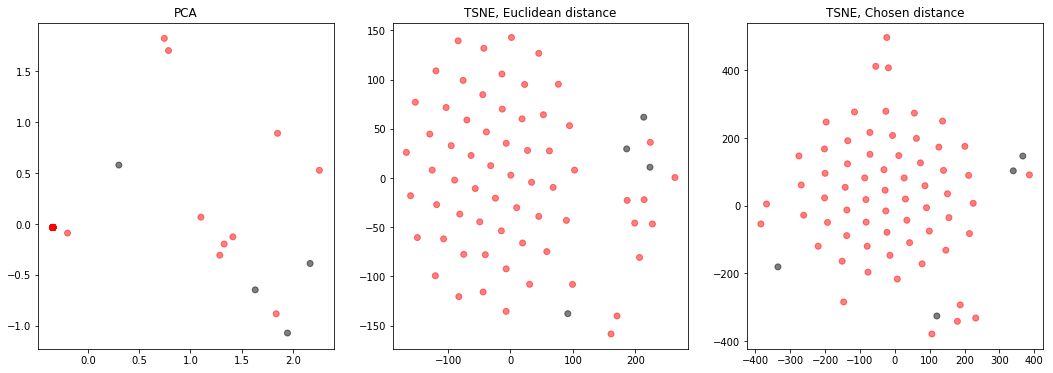

Clustering


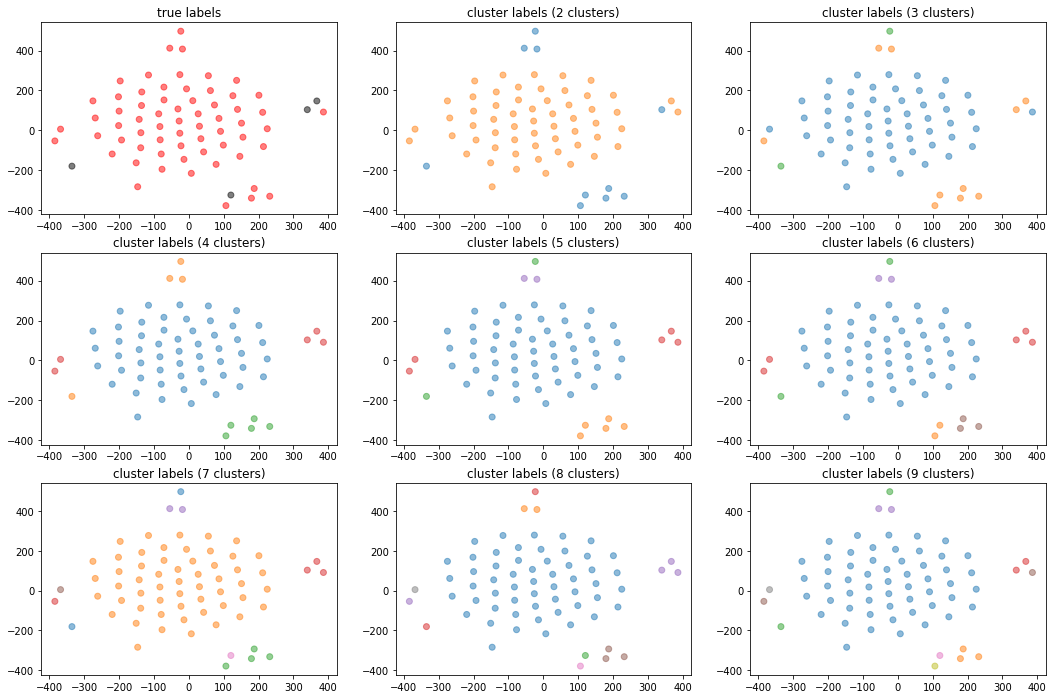

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.983271,0.826743,0.766412,0.828539,0.631954,0.0,2.179608e-11,4.991215e-12,0.000001,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.005288,0.013853,0.012808,0.017857,0.012560
1,0.048288,0.349190,0.118817,0.375393,0.336508,0.0,1.587990e-01,9.526557e-03,0.014100,0.177459,...,0.0,0.0,0.0,0.0,0.0,0.260676,0.221248,0.232156,0.233255,0.158525
2,0.056774,0.017278,0.028146,0.044687,0.009779,0.0,3.090394e-01,5.109608e-01,0.522379,0.245478,...,0.0,0.5,0.5,0.5,0.0,0.283928,0.492322,0.475587,0.640069,0.385554


In [14]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

In [15]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

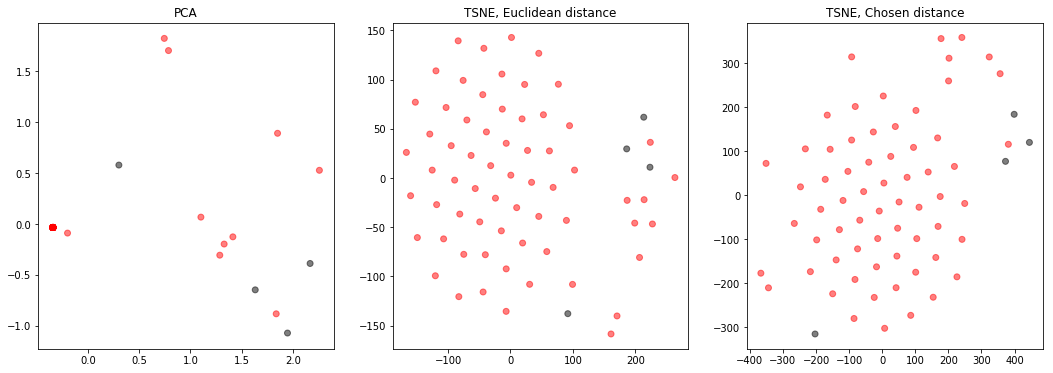

Clustering


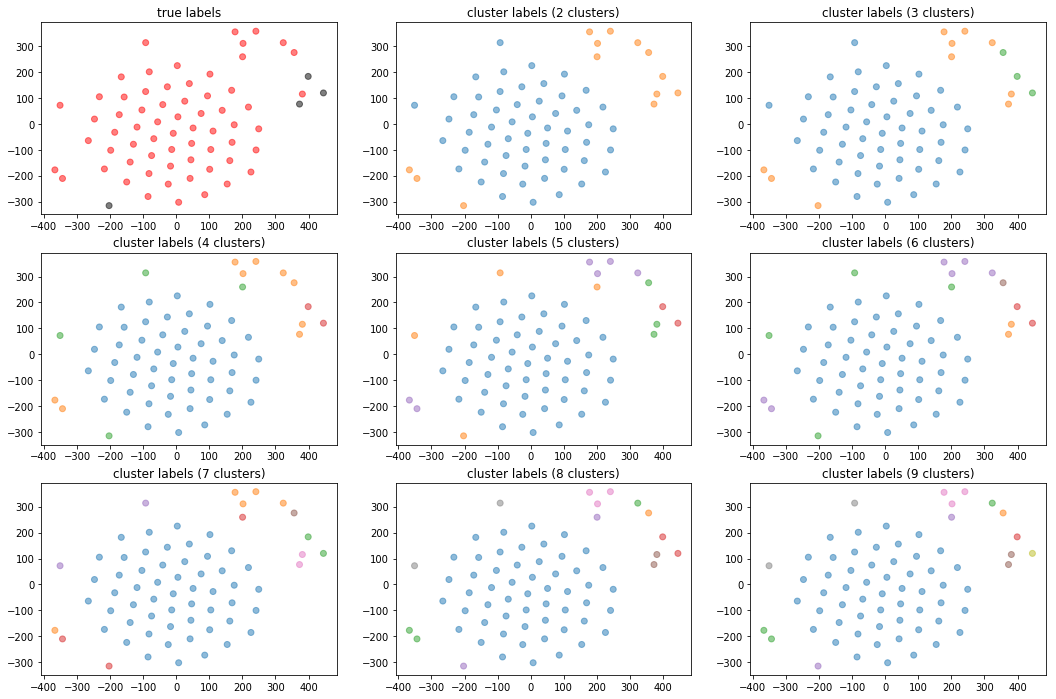

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.061079,0.352432,0.117051,0.385685,0.336298,0.0,5.879903e-02,6.897329e-03,0.009835,0.077459,...,0.0,0.000000,0.000000,0.000000,0.0,0.289364,0.298581,0.303550,0.332983,0.228410
2,0.037849,0.011519,0.025022,0.029791,0.007847,0.0,5.393596e-01,3.494046e-01,0.362466,0.496986,...,0.0,0.333333,0.333333,0.333333,0.0,0.192377,0.329025,0.318162,0.427620,0.258542


In [16]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

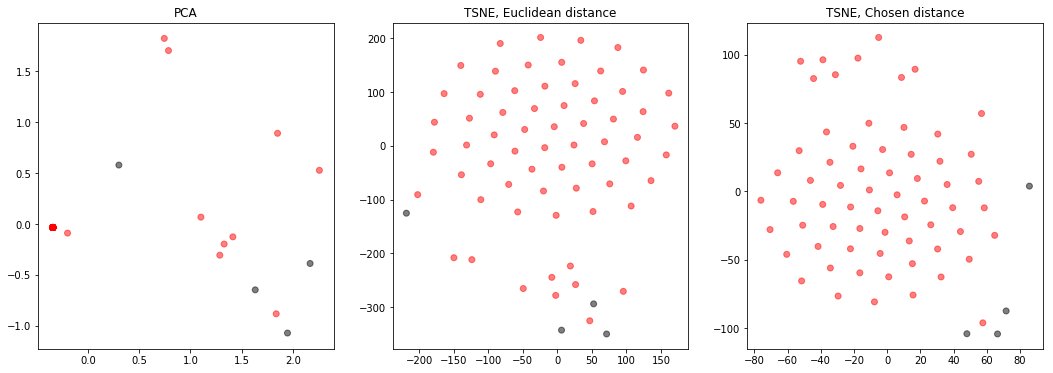

Clustering


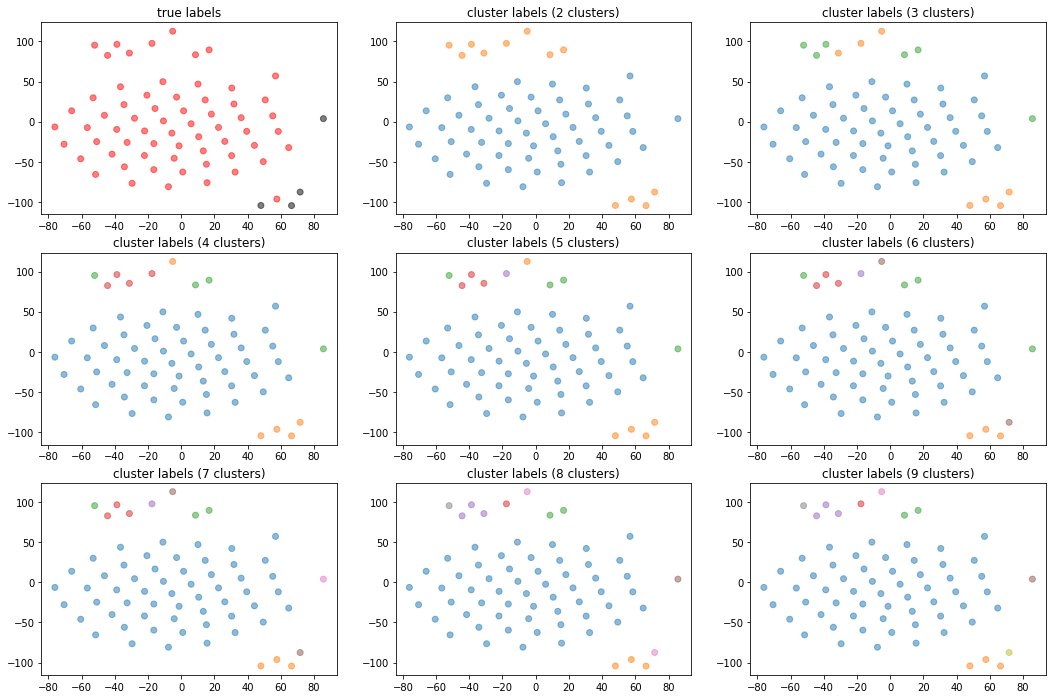

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.025689,0.023861,0.021667,0.049274,0.013779,0.0,4.412138e-01,2.234374e-01,0.237151,0.45311,...,0.0,0.2,0.2,0.2,0.0,0.115426,0.197415,0.190897,0.256572,0.155125
2,0.092688,0.742065,0.282400,0.762685,0.756293,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.588627,0.519398,0.539355,0.540585,0.362182
3,0.032410,0.146298,0.002177,0.182064,0.096857,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.080992,0.044151,0.053610,0.055831,0.044000
4,0.127907,0.032420,0.001113,0.102921,0.001878,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.296155,0.775761,0.717251,1.000000,0.703375


In [17]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

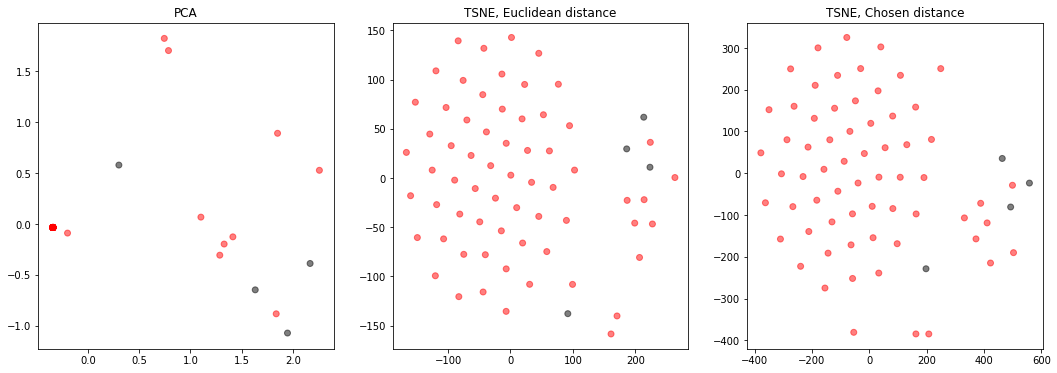

Clustering


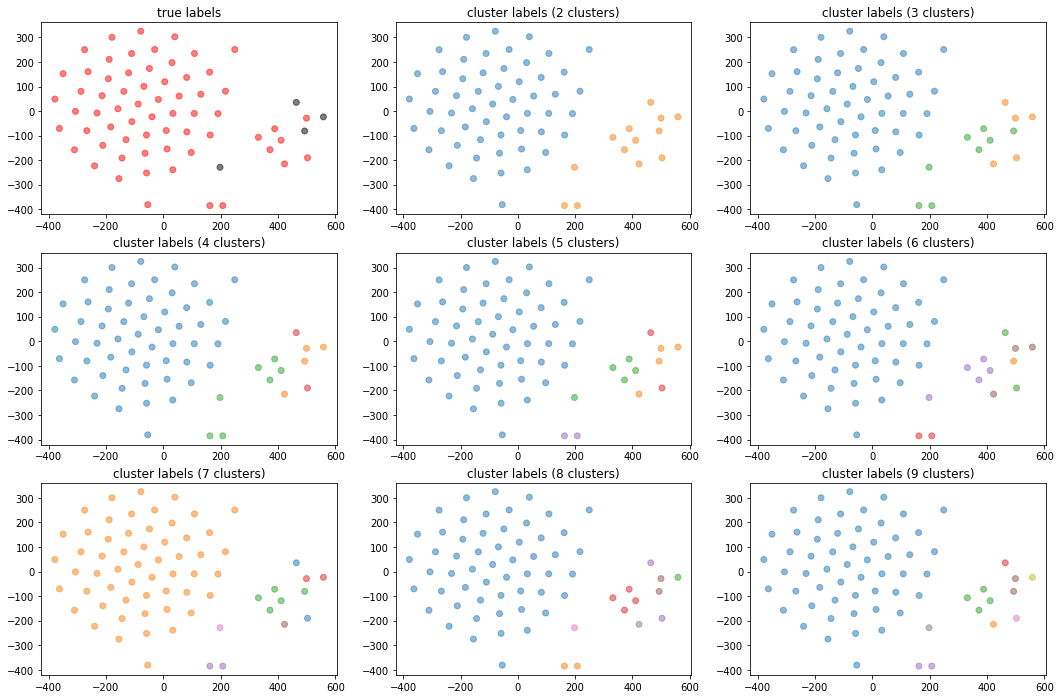

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.049104,0.018112,0.017292,0.047830,0.007118,0.0,4.087502e-01,2.213899e-01,0.230967,0.45311,...,0.0,0.2,0.2,0.2,0.0,0.174657,0.352567,0.334347,0.456572,0.295800
2,0.059852,0.433540,0.144890,0.463384,0.418866,0.0,2.028978e-02,1.279690e-03,0.003865,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.324686,0.276256,0.289781,0.291229,0.197591


In [18]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

- ### braycurtis $$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

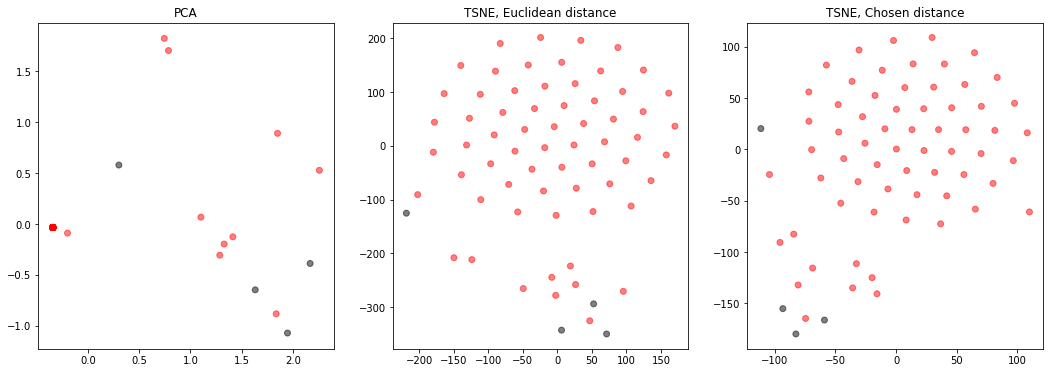

Clustering


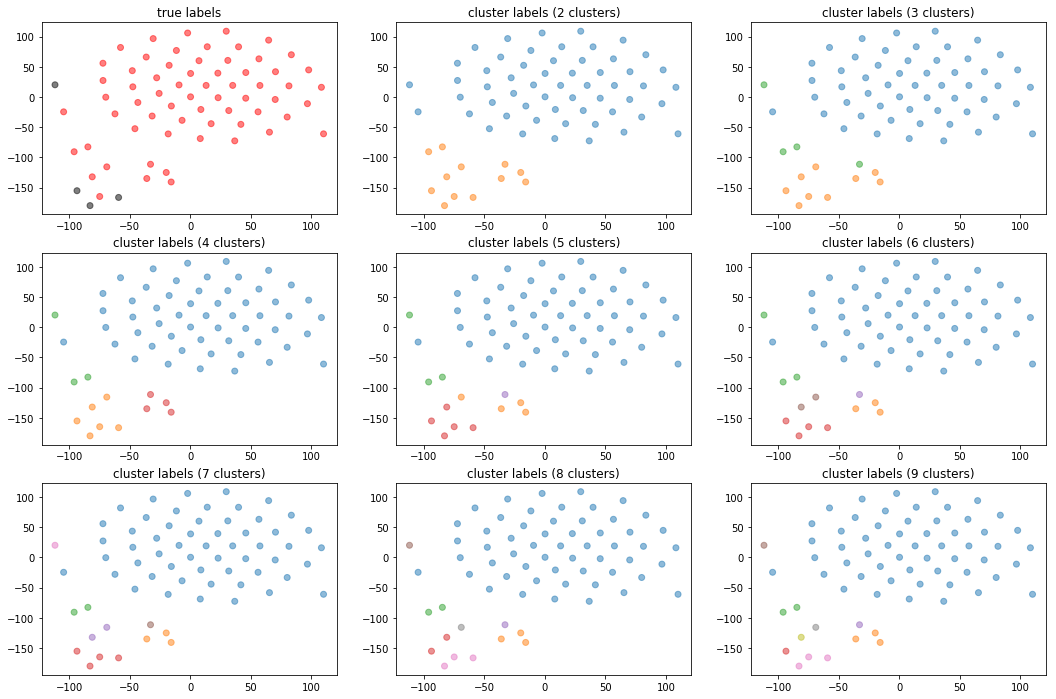

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.039287,0.065624,0.012886,0.099498,0.040149,0.0,2.451188e-01,1.241319e-01,0.131750,0.251728,...,0.0,0.111111,0.111111,0.111111,0.0,0.124029,0.210588,0.203618,0.272261,0.179000
2,0.092688,0.742065,0.282400,0.762685,0.756293,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.588627,0.519398,0.539355,0.540585,0.362182


In [19]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

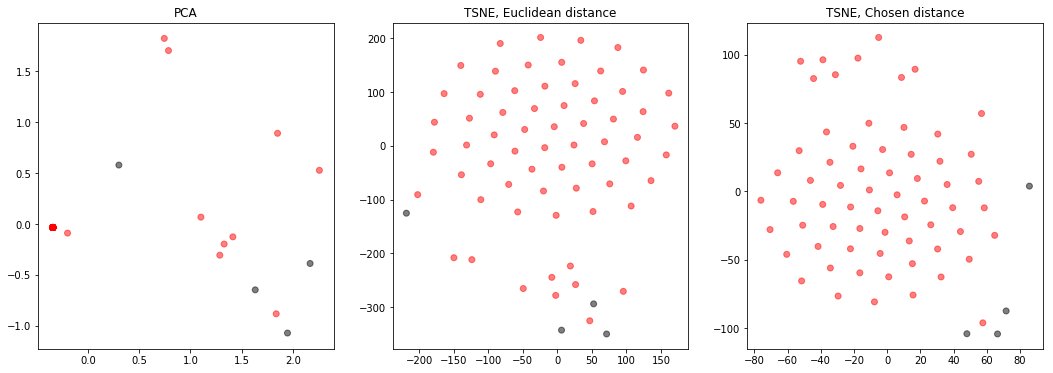

Clustering


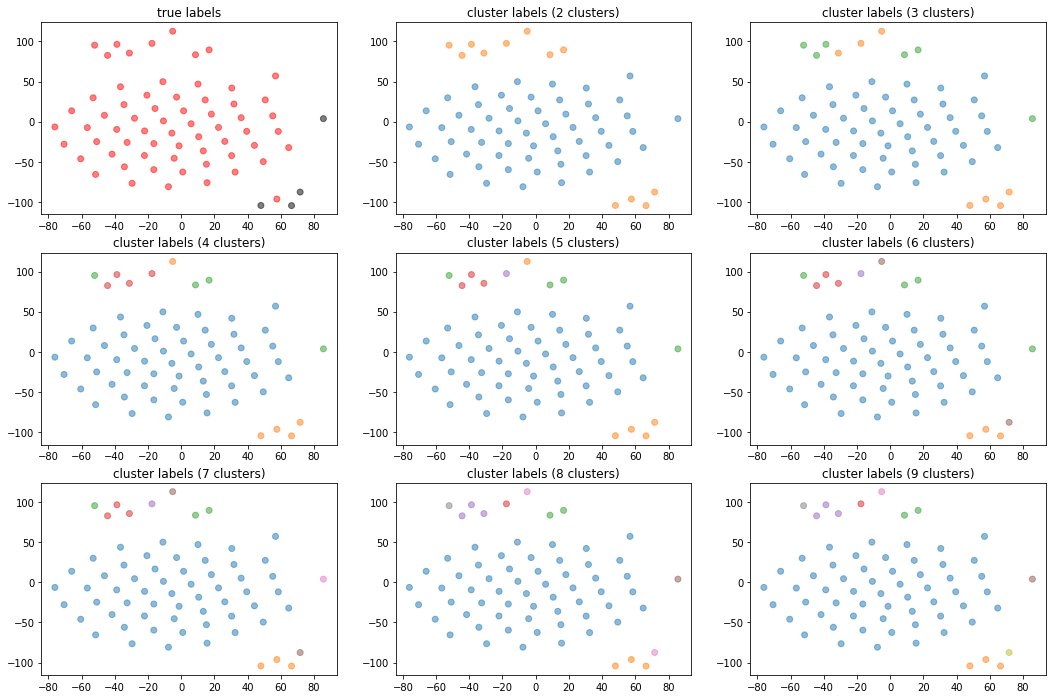

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.038344,0.037887,0.016567,0.065954,0.024864,0.0,3.151527e-01,1.595982e-01,0.169393,0.32365,...,0.0,0.142857,0.142857,0.142857,0.0,0.142504,0.269582,0.256568,0.340700,0.212988
2,0.075988,0.548945,0.188268,0.580758,0.535411,0.0,0.000000e+00,0.000000e+00,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.412207,0.347635,0.365668,0.371299,0.261468


In [20]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

# Spectra comparation

In [21]:
import matplotlib.gridspec as gridspec
def show_marked_spectra(spectrum_columns, spectra=spectra, simbad_number=6):
    plt.clf()
    plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(4, 2, wspace=0.1, hspace=0.02)
    marked_spectra = spectra[spectra['marked'] == 1]
    non_normalized_marked_spectra = non_normalized_spectra[non_normalized_spectra['marked'] == 1]
    axes = []
    for i in range(0,4):

        table = marked_spectra[spectrum_columns].iloc[i]
        values = table.values
        spectrum_order = np.hstack((values[simbad_number:],values[0:simbad_number]))

        non_normalized_table = non_normalized_marked_spectra[spectrum_columns].iloc[i]
        non_normalized_values = non_normalized_table.values
        non_normalized_spectrum_order = np.hstack((non_normalized_values[simbad_number:],non_normalized_values[0:simbad_number]))
        spectra_points_number = len(spectrum_columns)
        ax = plt.subplot(gs[i, 0])
        plt.xticks(())
        if i == 0:
            plt.setp([ax], title='Normalized columns')
        if i == 3:
            ax.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.plot(range(len(values)), spectrum_order)
        ax.set_ylabel(marked_spectra['s_MAIN_ID'].values[i])

        ax = plt.subplot(gs[i, 1])        
        plt.xticks(())
        if i== 0:
            plt.setp([ax], title='Non normalized columns')
        if i == 3:
            ax.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.plot(range(len(values)), non_normalized_spectrum_order)    

    plt.show()

In [22]:
def show_marked_spectra2(spectrum_columns, spectra=spectra, simbad_number=6):
    plt.clf()
    fig, ax = plt.subplots(figsize=(16,6))
    marked_spectra = spectra[spectra['marked'] == 1]
    for i in range(0,4):

        table = marked_spectra[spectrum_columns].iloc[i]
        values = table.values
        spectrum_order = np.hstack((values[simbad_number:],values[0:simbad_number]))

        spectra_points_number = len(spectrum_columns)
        plt.xticks(())
        #if i == 0:
        #    plt.setp([plt], title='Normalized columns')
        if i == 3:
            #plt.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))),rotation=45)
        ax.plot(range(len(values)), spectrum_order, label=marked_spectra['s_MAIN_ID'].values[i])
        legend = ax.legend(loc = 'upper right')   

    plt.show()

All catalogs for normalized columns and normalized spectra:

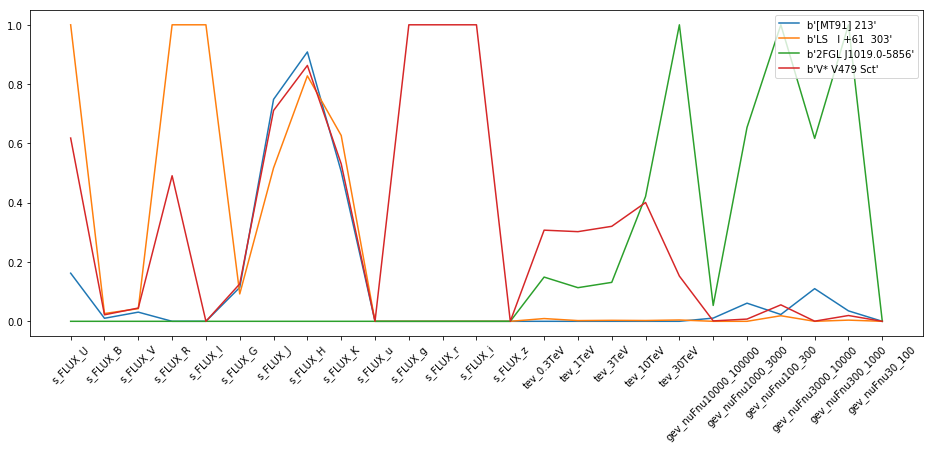

In [23]:
show_marked_spectra2(spectrum_columns)

All catalogs for non normalized columns and normalized spectra:

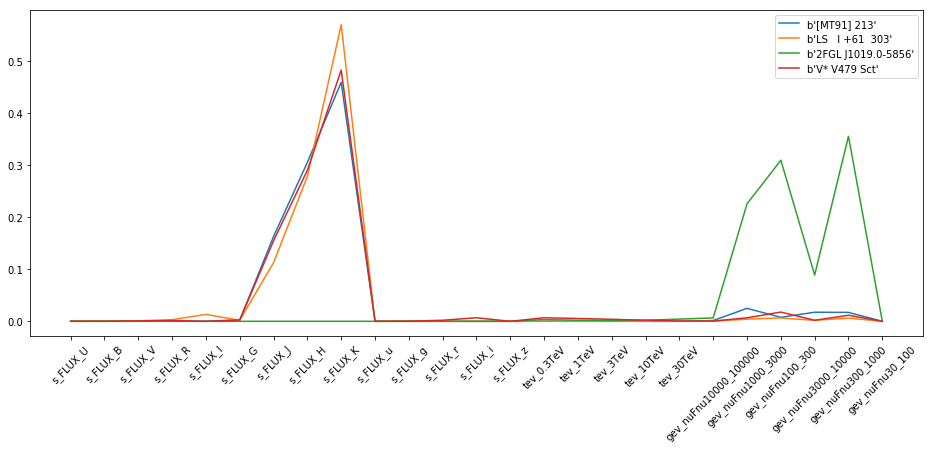

In [24]:
show_marked_spectra2(spectrum_columns, non_normalized_spectra)

In [29]:
path_to_catalog = "markeddata/non_normalized_spectra.txt"
spectra_without_line_normalization = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra_without_line_normalization.head()


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,2.098420e-11,2.096862e-11,1.266728e-12,2.274123e-11,7.566604e-12,0.0,0.0,6.918312e-12,3.090294e-11,0.0,...,1.204573e-11,6.969757e-12,4.125786e-12,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,4.706814e-12,5.332763e-11,5.145968e-13,2.923599e-11,3.387356e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,4.000469e-13,2.969888e-13,4.585589e-13,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


All catalogs for non normalized columns and non normalized spectra:

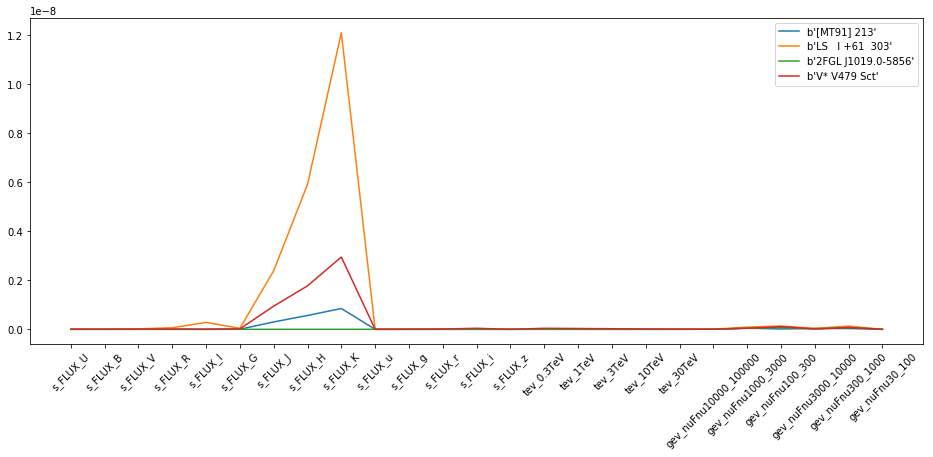

In [31]:
show_marked_spectra2(spectrum_columns, spectra_without_line_normalization)

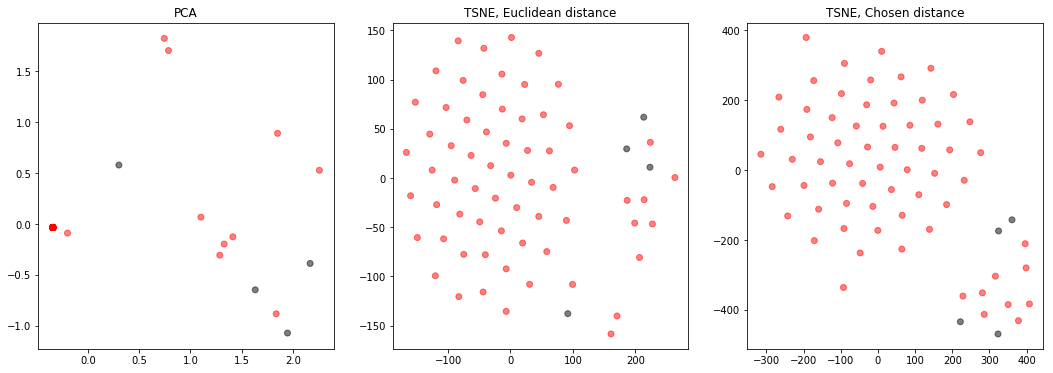

Clustering


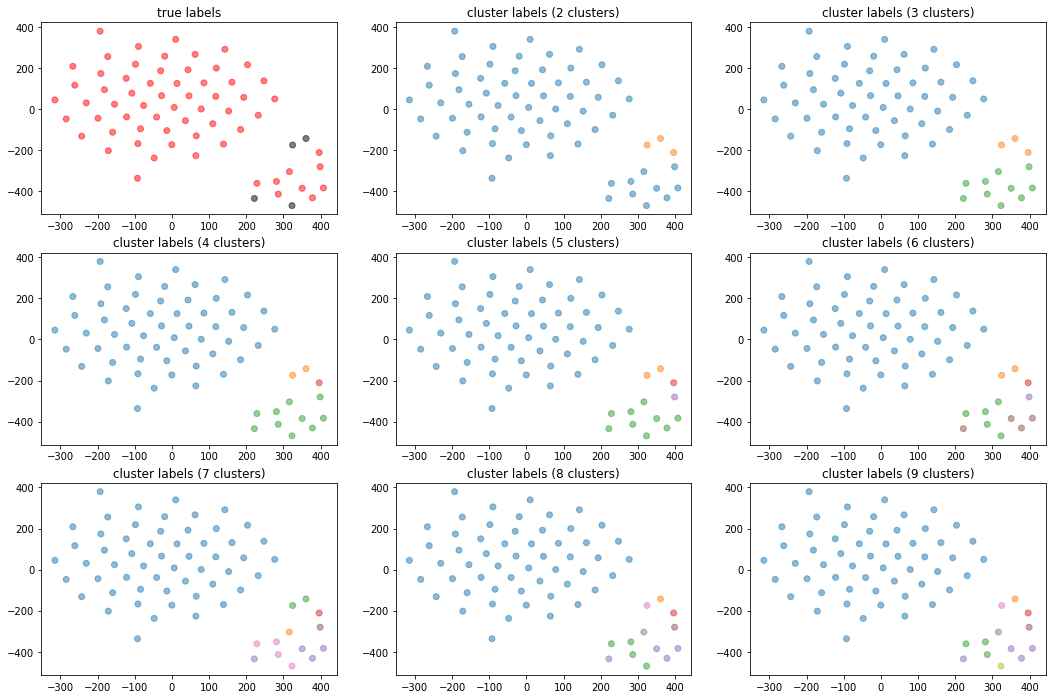

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.998823,0.841185,0.780327,0.841732,0.643410,0.0,2.219238e-11,5.081964e-12,0.000001,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.037849,0.011519,0.025022,0.029791,0.007847,0.0,5.393596e-01,3.494046e-01,0.362466,0.496986,...,0.0,0.333333,0.333333,0.333333,0.0,0.192377,0.329025,0.318162,0.427620,0.258542
2,0.061079,0.352432,0.117051,0.385685,0.336298,0.0,5.879903e-02,6.897329e-03,0.009835,0.077459,...,0.0,0.000000,0.000000,0.000000,0.0,0.289364,0.298581,0.303550,0.332983,0.228410


In [32]:
x = spectra_without_line_normalization[spectrum_columns].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
spectra_without_line_normalization[spectrum_columns] = pd.DataFrame(x_scaled)

# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra_without_line_normalization[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

All catalogs for normalized columns and non normalized spectra:

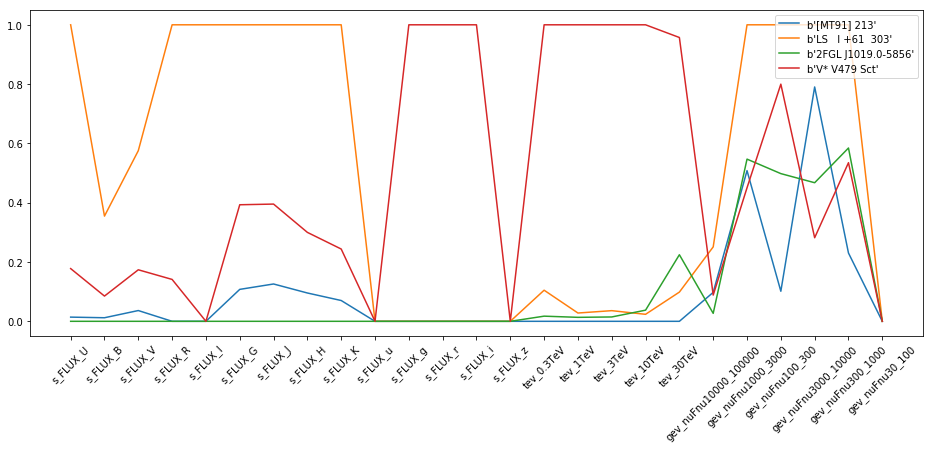

In [33]:
show_marked_spectra2(spectrum_columns, spectra_without_line_normalization)

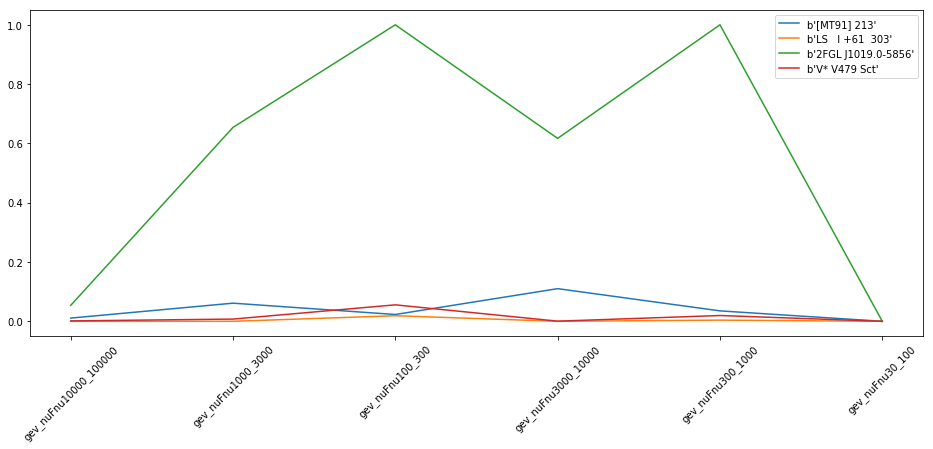

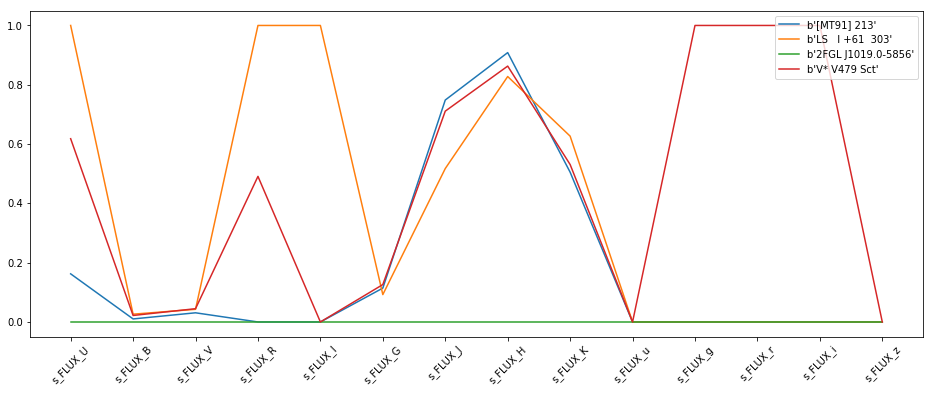

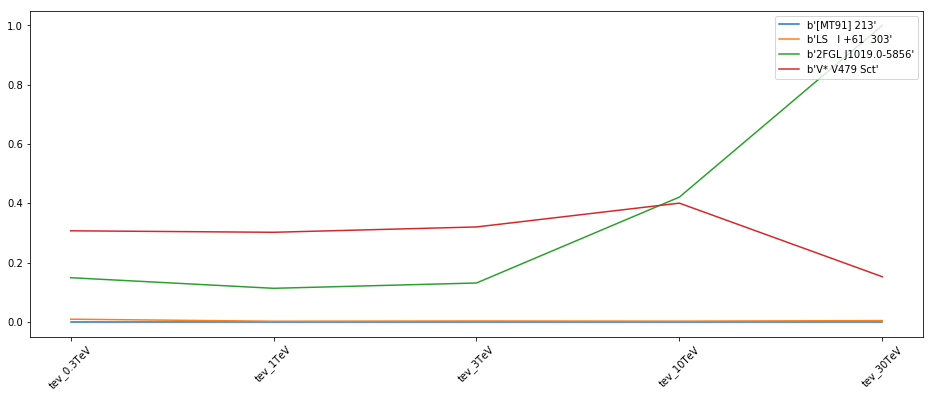

In [34]:
show_marked_spectra2(spectrum_columns[0:6], spectra, 0)
show_marked_spectra2(spectrum_columns[6:20], spectra, 0)
show_marked_spectra2(spectrum_columns[20:], spectra, 0)

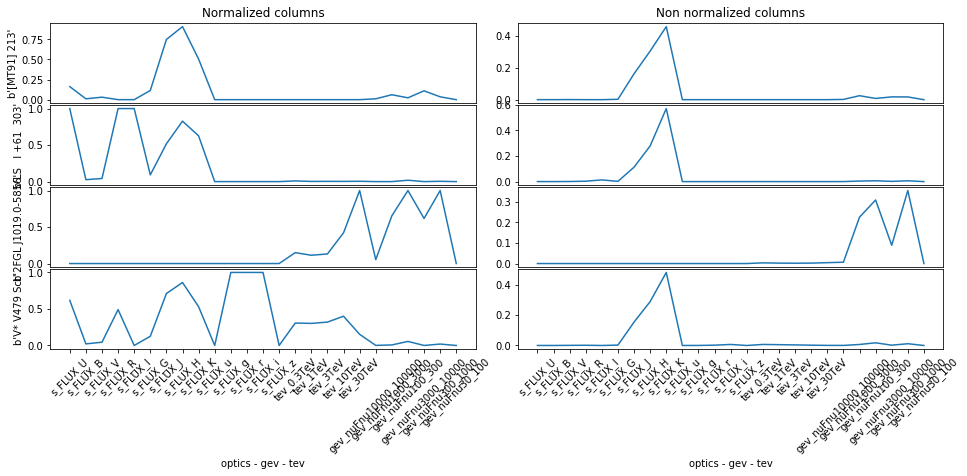

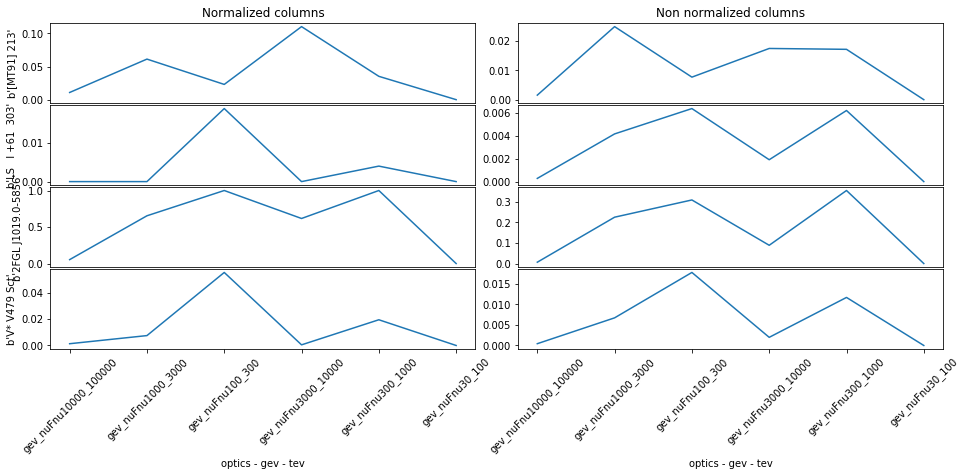

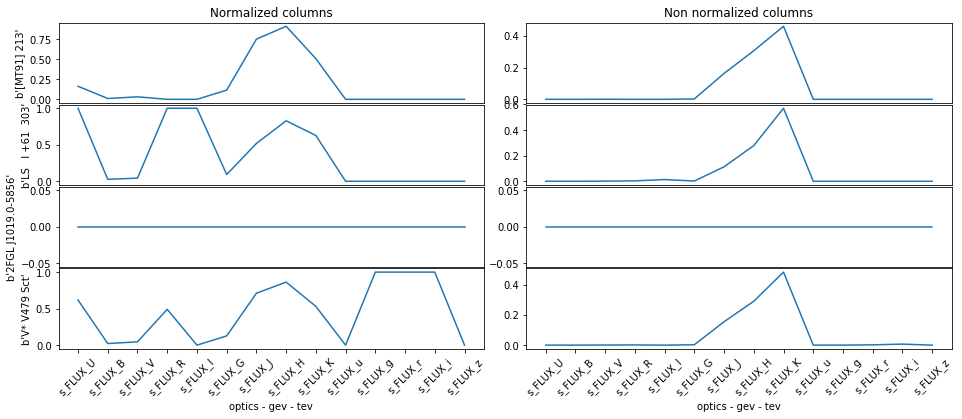

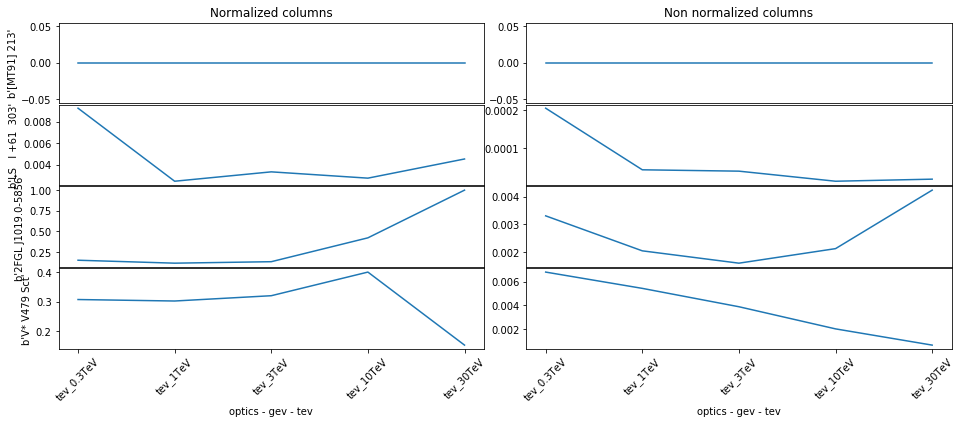

In [35]:
show_marked_spectra(spectrum_columns)
show_marked_spectra(spectrum_columns[0:6], spectra, 0)
show_marked_spectra(spectrum_columns[6:20], spectra, 0)
show_marked_spectra(spectrum_columns[20:], spectra, 0)